In [1]:
import torch
import torch.nn as nn
import torch.optim as optim # get access to optimizes the weight
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader

import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import json
from IPython.display import display, clear_output
from sklearn.metrics import confusion_matrix
#from plotcm import plot_confusion_matrix

import pdb
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

from torch.utils.tensorboard import SummaryWriter
from collections import OrderedDict
from collections import namedtuple
from itertools import product

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image

import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from datetime import datetime

import re

%matplotlib inline
from functools import partial

In [2]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [3]:
path="X-Ray Image DataSet/"
img_name=[]
label=[]
for root, directories, files in os.walk(path):
    for file in files:
        img_name.append(root+"/"+file)
        label.append(root.split("/")[-1])

In [4]:
train_img_name, val_img_name, train_label, val_label = train_test_split(img_name, 
                                                                        label, test_size=0.2, random_state=50, stratify=label)

In [5]:
train_Aug = torchvision.transforms.Compose([torchvision.transforms.Resize((448, 448)),
                                            torchvision.transforms.RandomRotation((-20, 20)),
                                            torchvision.transforms.RandomAffine(0, translate=None, scale=[0.7, 1.3], 
                                            shear=None, resample=False, fillcolor=0),                                            
                                            transforms.ToTensor()])
test_Aug = torchvision.transforms.Compose([torchvision.transforms.Resize((448, 448)), 
                                           transforms.ToTensor()])

In [6]:
class CustomDatasetFromImages(torch.utils.data.Dataset):
    
    def __init__(self, img_name, label, transforms=None): 
        self.image_arr = np.asarray(img_name)
        self.label_arr = np.asarray(label, dtype=np.float64)
        self.data_len = len(img_name)
        self.transforms = transforms
    
    def __getitem__(self, index):
        single_img_name = self.image_arr[index]
        img_array = Image.open(single_img_name).convert('RGB')
        if self.transforms is not None:
            img_array = self.transforms(img_array)
        image_label = self.label_arr[index]
        return (img_array, image_label)
      
    
    def __len__(self):
        return self.data_len

In [29]:
train_set=CustomDatasetFromImages(train_img_name, train_label, transforms=train_Aug)
test_set=CustomDatasetFromImages(val_img_name, val_label, transforms=test_Aug)
trainloader= torch.utils.data.DataLoader(train_set, batch_size=8, num_workers=0,shuffle=True) 
testloader=torch.utils.data.DataLoader(test_set, batch_size=8, num_workers=0, shuffle=False)

In [8]:
nonlinearity = partial(F.relu, inplace=True)

class Mutiplekernel(nn.Module):
    def __init__(self, channel, channel2):
        super(Mutiplekernel, self).__init__()
        self.conv1 = nn.Conv2d(channel, channel, 3,stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(channel)
        self.conv2 = nn.Conv2d(channel, channel, 5,stride=1, padding=2)
        self.bn2   = nn.BatchNorm2d(channel)
        self.conv3 = nn.Conv2d(channel, channel, 3,stride=1, padding=1)
        self.bn3   = nn.BatchNorm2d(channel)
        self.conv4 = nn.Conv2d(channel, channel, 7,stride=1, padding=3)
        self.bn4   = nn.BatchNorm2d(channel)
        self.conv5 = nn.Conv2d(4 *channel, channel2, kernel_size=1, dilation=1, padding=0)
        self.bn5   = nn.BatchNorm2d(channel2)
        self.conv6 = nn.Conv2d(channel, channel2, 1,stride=1, padding=0)
        self.bn6   = nn.BatchNorm2d(channel2)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        C1_out = nonlinearity(self.bn1(self.conv1(x)))
        C2_out = nonlinearity(self.bn2(self.conv2(x)))
        C3_out = nonlinearity(self.bn3(self.conv3(x)))
        C4_out = nonlinearity(self.bn4(self.conv4(x)))
        C5_cat = torch.cat([C1_out, C2_out, C3_out, C4_out], 1)
        C5_out = nonlinearity(self.bn5(self.conv5(C5_cat)))
        C6_out = nonlinearity(self.bn6(self.conv6(x)))
        out = C5_out + C6_out
        return out

In [9]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        resnet = torchvision.models.resnet34(pretrained=True)
        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
#         self.encoder2 = resnet.layer2
#         self.encoder3 = resnet.layer3
#         self.encoder4 = resnet.layer4
        
        self.pooling1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=1)
        self.multiplekernel1 = Mutiplekernel(64,128)
        self.pooling2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.multiplekernel2 = Mutiplekernel(128,128)
        self.pooling3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.multiplekernel3 = Mutiplekernel(128,256)
        self.pooling4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.multiplekernel4 = Mutiplekernel(256,256)
        
        self.fc = nn.Linear(in_features=256*7*7, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=2)
        
        
    def forward(self, x):
        # Encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
#         e2 = self.encoder2(e1)
#         e3 = self.encoder3(e2)
#         e4 = self.encoder4(e3)
        pol1 = self.pooling1(e1)
        mk1 = self.multiplekernel1(pol1)
        pol2 = self.pooling2(mk1)
        mk2 = self.multiplekernel2(pol2)
        pol3 = self.pooling3(mk2)
        mk3 = self.multiplekernel3(pol3)
        pol4 = self.pooling3(mk3)
        mk4 = self.multiplekernel4(pol4)
        mk4 = mk4.reshape(-1,256*7*7)
        fc = self.fc(mk4)
        output = self.out(fc)
        
        return output
        

In [10]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [11]:
model = Network().to(device)
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [31]:
# number of epochs to train the model
testaccuracy = []
trainlosses = []
validlosses = []
totalepoch = []
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
    
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    accuracy = 0
    correct = 0
    total = 0
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in trainloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target.to(device=device, dtype=torch.int64))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in testloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target.to(device=device, dtype=torch.int64))
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
        # Calculate accuracy
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()   
        
    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    trainlosses.append(train_loss)
    valid_loss = valid_loss/len(testloader.sampler)
    validlosses.append(valid_loss)
    testaccuracy.append(accuracy/len(testloader))
    totalepoch.append(epoch)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f}' .format(
        epoch, train_loss, valid_loss, (accuracy/len(testloader))))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_covid.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.035915 	Validation Loss: 0.052744 	Accuracy: 0.984375
Validation loss decreased (inf --> 0.052744).  Saving model ...
Epoch: 2 	Training Loss: 0.021307 	Validation Loss: 0.058307 	Accuracy: 0.976562
Epoch: 3 	Training Loss: 0.045870 	Validation Loss: 0.104347 	Accuracy: 0.960938
Epoch: 4 	Training Loss: 0.024825 	Validation Loss: 0.036726 	Accuracy: 1.000000
Validation loss decreased (0.052744 --> 0.036726).  Saving model ...
Epoch: 5 	Training Loss: 0.017799 	Validation Loss: 0.401706 	Accuracy: 0.898438
Epoch: 6 	Training Loss: 0.023308 	Validation Loss: 0.257802 	Accuracy: 0.859375
Epoch: 7 	Training Loss: 0.020557 	Validation Loss: 0.098337 	Accuracy: 0.968750


KeyboardInterrupt: 

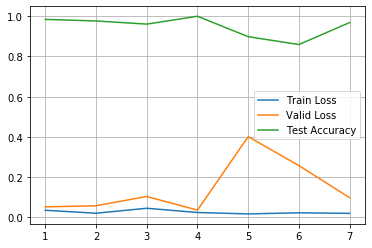

In [33]:
from matplotlib import pyplot as plt
plt.plot(totalepoch, trainlosses, label='Train Loss')
plt.plot(totalepoch, validlosses, label='Valid Loss')
plt.plot(totalepoch, testaccuracy, label='Test Accuracy')
plt.legend()
plt.grid()
plt.show()

In [13]:
@torch.no_grad()
def get_all_preds(model, testloader):
    all_preds = torch.tensor([]).to(device)
    for batch in testloader:
        images, labels = batch

        preds = model(images.to(device))
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [14]:
prediction_loader = torch.utils.data.DataLoader(test_set, batch_size=8)
test_preds = get_all_preds(model, prediction_loader)

In [15]:
import matplotlib.pyplot as plt
import pdb
torch.set_printoptions(linewidth=120)
from sklearn.metrics import confusion_matrix
from resources.plotcm import plot_confusion_matrix

cm = confusion_matrix(test_set.label_arr, test_preds.cpu().argmax(dim=1))
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[100,   0],
       [  8,  17]], dtype=int64)

In [89]:
cm.sum()

125

Confusion matrix, without normalization
[[100   0]
 [  8  17]]


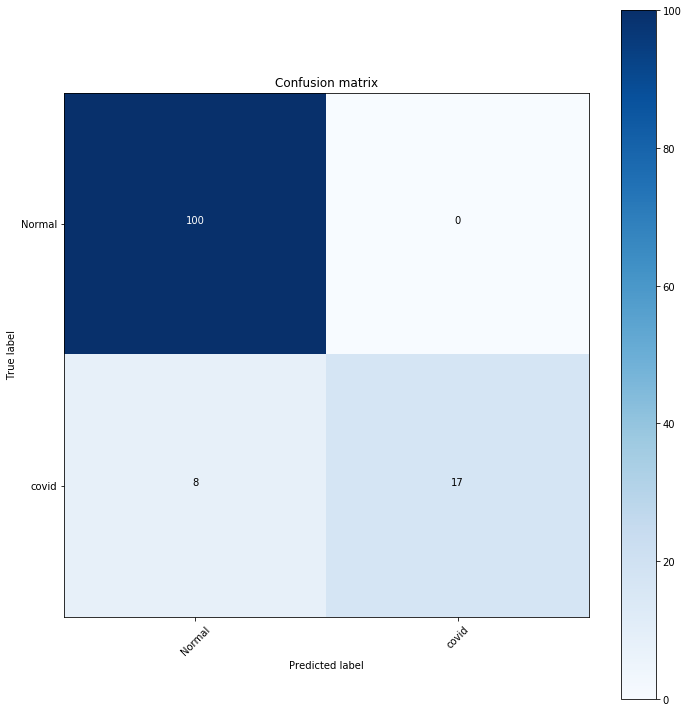

In [16]:
names = (
    'Normal','covid'
)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)

In [17]:
from sklearn.metrics import classification_report
probs = np.argmax(test_preds.cpu(), axis=1)
# y_true1 = targets
# y_pred1 = probs
target_names = ['Normal','Covid-19']
print(classification_report(test_set.label_arr, probs, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.93      1.00      0.96       100
    Covid-19       1.00      0.68      0.81        25

    accuracy                           0.94       125
   macro avg       0.96      0.84      0.89       125
weighted avg       0.94      0.94      0.93       125



In [18]:
# FP = cm.sum(axis=0) - np.diag(cm)  
# FN = cm.sum(axis=1) - np.diag(cm)
# TP = np.diag(cm)
# TN = confusion_matrix.values.sum() - (FP + FN + TP)
TN, FP, FN, TP = cm.ravel()
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [19]:
TN, FP, FN, TP

(100, 0, 8, 17)

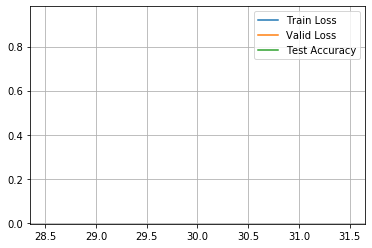

In [ ]:
import matplotlib.pyplot as plt
import pdb
torch.set_printoptions(linewidth=120)
from sklearn.metrics import confusion_matrix
from resources.plotcm import plot_confusion_matrix

cm = confusion_matrix(train_set.label_arr, train_preds.cpu().argmax(dim=1))
print(type(cm))
cm

In [ ]:
names = (
    'covid','normal'
)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)

In [3]:
from numpy import array
from sklearn.model_selection import KFold
# data sample
data = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
# prepare cross validation
kfold = KFold(3, True, 1)
# enumerate splits
for train, test in kfold.split(data):
	print('train: %s, test: %s' % (data[train], data[test]))

train: [0.1 0.4 0.5 0.6], test: [0.2 0.3]
train: [0.2 0.3 0.4 0.6], test: [0.1 0.5]
train: [0.1 0.2 0.3 0.5], test: [0.4 0.6]
